# RDM in an advanced data pipeline on an HPC cluster
## Introduction
In this tutorial are working through parts of the computational pipeline in https://doi.org/10.3389/fgene.2013.00289.
The pipeline deals with the problem to find out the best configuration for predicting the outcome of breast cancer patients based on their gene expression profiles. One major aspect in the performance of the classification is the selection of features. Several methods to select genes or groups of genes are compared in a double-loop cross validation procedure. For simplicity in this tutorial we only focus on two benchmark methods to select genes (Single genes and Random genes) and one method, Lee, which uses pathways to group genes and classfify then with the aggregated statistics over these genes.
We will also only use one classifier model, the neares mean classifier with the standard metric. And to keep running times down we will also only execute a 5-fold cross validation.

The experssion dataset is published on figshare and we will download it during the pipeline from this external source. The curated pathway data, which is necessary for the Lee method to define features, lies in the iRODS instance and is annotated by some metadata. 

## Step-by-step guide
### 1. Install dependencies
Before we start the computationa pipeline, we need to make sure that all necessary python modules are installed

In [ ]:
pip install scikit-learn python-irodsclient wget h5py

### 2. Imports
Here we import some standard python modules, the irods python modules, some own functions to ease the interaction with iRODS and of course our own software ACES, which implements the datatypes and analysis.

In [27]:
#Standard python modules
import json
import os
import datetime
import numpy
import matplotlib
#matplotlib.use('Agg')
import matplotlib.pyplot as plt
import csv
import wget
import pprint

#iRODS python modules
from irods.session import iRODSSession
from irods.models import Collection, DataObject, CollectionMeta, DataObjectMeta
from irods.access import iRODSAccess
#Own python functions to wrap lengthy iRODS code
from helperFunctions import *

#Imports from the ACES software
from SetUpGrid import CombineData
from CreateTokens import generate_tokens
from SetUpGrid import SetUpRun
from SetUpGrid import RunInstance

### 3. Connection to iRODS
Here we define the parameters which are needed to connect to iRODS and setup the connection:

**Please adjust the user, password and share!**

In [ ]:
host = "<IP or FQDN>"
port = 1247
user = "<irods user>"
password = "<irods password>"
zone = "aliceZone"
session = iRODSSession(host=host, port=port, user=user, password=password, zone=zone)

### Login to SSL enabled iRODS or YODA
To increase the security of messages exchanged between you and the iRODS server SSL encryption is used. In that case your iRODS sys-admin will give you a file `irods-environment.json` which contains all parameters to connect to the server. Please store that file in your home-directory `~/.irods/irods-environment.json`.
We will use thios file to connect to the iRODS server like this:

In [28]:
with open('passwd', 'r') as f:
    passwd = f.readline().strip()
    
with open(os.path.expanduser("~/.irods/irods_environment.json"), "r") as f:
    ienv = json.load(f)
session = iRODSSession(**ienv, password=passwd)

### 4. Parameters for our computational pipeline
- Setting up the folder structure on fast storage of the compute cluster. The data stored here is not backed up, nor safely stored, this storage is just used to allow very quick calculations on the data.
- Keywords and their values to search for the correct data in iRODS
- Prepare a collection on the iRODS instance to gather our results

**Please adjust the paths!**

In [29]:
data_dir = os.path.expanduser("~/aces_data")
results_dir = os.path.expanduser("~/aces_results")
ensure_dir(data_dir)
ensure_dir(results_dir)

Now we can search for our curated pathway data in iRODS.

In [30]:
ATTR_NAME = 'DATATYPE'
ATTR_VALUE = 'PATHWAYS'
query = session.query(Collection.name, DataObject.name)
filteredQuery = query.filter(DataObjectMeta.name == ATTR_NAME).\
                          filter(DataObjectMeta.value == ATTR_VALUE)


In [31]:
print(filteredQuery.all())

+--------------------------------------------------------+---------------------------------------+
| COLL_NAME                                              | DATA_NAME                             |
+--------------------------------------------------------+---------------------------------------+
| /nluu12p/home/research-test-christine/iRODS-setup-ACES | C2V3_PathwayGeneSets_Entrez_Aug12.txt |
| /nluu12p/home/research-test-christine/iRODS-setup-ACES | C2V3_PathwayGeneSets_Entrez.txt       |
| /nluu12p/home/research-test-christine/iRODS-setup-ACES | KEGG1210_PathwayGeneSets_Entrez.txt   |
| /nluu12p/home/research-test-christine/iRODS-setup-ACES | KEGG_PathwayGeneSets_Entrez_Aug12.txt |
+--------------------------------------------------------+---------------------------------------+


And download the data to our directory on the scratch file system.

In [32]:
irods_paths = parse_query(filteredQuery)
print('Downloading: ')
print('\n'.join(irods_paths))
get_data(session, irods_paths, data_dir)

Downloading: 
/nluu12p/home/research-test-christine/iRODS-setup-ACES/C2V3_PathwayGeneSets_Entrez_Aug12.txt
/nluu12p/home/research-test-christine/iRODS-setup-ACES/C2V3_PathwayGeneSets_Entrez.txt
/nluu12p/home/research-test-christine/iRODS-setup-ACES/KEGG1210_PathwayGeneSets_Entrez.txt
/nluu12p/home/research-test-christine/iRODS-setup-ACES/KEGG_PathwayGeneSets_Entrez_Aug12.txt
Write to:  /Users/staig001/aces_data


The gene expression data for the pipeline is published data in Figshare. Let's download it:

In [33]:
url = "https://ndownloader.figshare.com/files/4851460"
fileName = "4851460"
wget.download(url, out=data_dir)

  0% [                                                  ]   2392064 / 250428371

  2% [.                                                 ]   5603328 / 250428371

  3% [.                                                 ]   7520256 / 250428371

  3% [.                                                 ]   9551872 / 250428371

  4% [..                                                ]  11354112 / 250428371

  5% [..                                                ]  12910592 / 250428371

  5% [..                                                ]  14483456 / 250428371

  6% [...                                               ]  16089088 / 250428371

  7% [...                                               ]  17989632 / 250428371

  7% [...                                               ]  19955712 / 250428371

  8% [....                                              ]  21807104 / 250428371

  9% [....                                              ]  23511040 / 250428371

 10% [.....                                             ]  25296896 / 250428371

 10% [.....                                             ]  27312128 / 250428371

 11% [.....                                             ]  28966912 / 250428371

 12% [......                                            ]  30523392 / 250428371

 12% [......                                            ]  32112640 / 250428371

 13% [......                                            ]  33734656 / 250428371

 14% [.......                                           ]  35364864 / 250428371

 14% [.......                                           ]  37027840 / 250428371

 15% [.......                                           ]  38862848 / 250428371

 16% [........                                          ]  40747008 / 250428371

 17% [........                                          ]  42647552 / 250428371

 17% [........                                          ]  44711936 / 250428371

 18% [.........                                         ]  46546944 / 250428371

 19% [.........                                         ]  48054272 / 250428371

 19% [.........                                         ]  49643520 / 250428371

 20% [..........                                        ]  51281920 / 250428371

 21% [..........                                        ]  52953088 / 250428371

 21% [..........                                        ]  54689792 / 250428371

 22% [...........                                       ]  56492032 / 250428371

 23% [...........                                       ]  58359808 / 250428371

 24% [............                                      ]  60293120 / 250428371

 24% [............                                      ]  61947904 / 250428371

 25% [............                                      ]  63373312 / 250428371

 25% [............                                      ]  64880640 / 250428371

 26% [.............                                     ]  66461696 / 250428371

 27% [.............                                     ]  68075520 / 250428371

 27% [.............                                     ]  69763072 / 250428371

 28% [..............                                    ]  71368704 / 250428371

 29% [..............                                    ]  73039872 / 250428371

 29% [..............                                    ]  74874880 / 250428371

 30% [...............                                   ]  76824576 / 250428371

 31% [...............                                   ]  78716928 / 250428371

 32% [................                                  ]  80166912 / 250428371

 32% [................                                  ]  81641472 / 250428371

 33% [................                                  ]  83181568 / 250428371

 33% [................                                  ]  84852736 / 250428371

 34% [.................                                 ]  86507520 / 250428371

 35% [.................                                 ]  88047616 / 250428371

 35% [.................                                 ]  89538560 / 250428371

 36% [..................                                ]  90849280 / 250428371

 36% [..................                                ]  92225536 / 250428371

 37% [..................                                ]  93667328 / 250428371

 37% [..................                                ]  95141888 / 250428371

 38% [...................                               ]  96681984 / 250428371

 39% [...................                               ]  98181120 / 250428371

 39% [...................                               ]  99811328 / 250428371

 40% [....................                              ] 101564416 / 250428371

 41% [....................                              ] 103383040 / 250428371

 42% [.....................                             ] 105299968 / 250428371

 42% [.....................                             ] 107216896 / 250428371

 43% [.....................                             ] 109199360 / 250428371

 44% [......................                            ] 110854144 / 250428371

 44% [......................                            ] 112377856 / 250428371

 45% [......................                            ] 113950720 / 250428371

 46% [.......................                           ] 115539968 / 250428371

 46% [.......................                           ] 117194752 / 250428371

 47% [.......................                           ] 118915072 / 250428371

 48% [........................                          ] 120487936 / 250428371

 48% [........................                          ] 122404864 / 250428371

 49% [........................                          ] 124305408 / 250428371

 50% [.........................                         ] 126058496 / 250428371

 50% [.........................                         ] 127467520 / 250428371

 51% [.........................                         ] 128974848 / 250428371

 52% [..........................                        ] 130514944 / 250428371

 52% [..........................                        ] 132136960 / 250428371

 53% [..........................                        ] 133627904 / 250428371

 54% [...........................                       ] 135348224 / 250428371

 54% [...........................                       ] 137134080 / 250428371

 55% [...........................                       ] 138788864 / 250428371

 56% [............................                      ] 140689408 / 250428371

 56% [............................                      ] 142704640 / 250428371

 57% [............................                      ] 144539648 / 250428371

 58% [.............................                     ] 146096128 / 250428371

 58% [.............................                     ] 147587072 / 250428371

 59% [.............................                     ] 149176320 / 250428371

 60% [..............................                    ] 150814720 / 250428371

 60% [..............................                    ] 152518656 / 250428371

 61% [..............................                    ] 154255360 / 250428371

 62% [...............................                   ] 156106752 / 250428371

 63% [...............................                   ] 157777920 / 250428371

 63% [...............................                   ] 159744000 / 250428371

 64% [................................                  ] 161480704 / 250428371

 65% [................................                  ] 162856960 / 250428371

 65% [................................                  ] 164249600 / 250428371

 66% [.................................                 ] 165822464 / 250428371

 66% [.................................                 ] 167444480 / 250428371

 67% [.................................                 ] 169148416 / 250428371

 68% [..................................                ] 170885120 / 250428371

 68% [..................................                ] 172703744 / 250428371

 69% [..................................                ] 174571520 / 250428371

 70% [...................................               ] 176488448 / 250428371

 71% [...................................               ] 178520064 / 250428371

 72% [....................................              ] 180371456 / 250428371

 72% [....................................              ] 181911552 / 250428371

 73% [....................................              ] 183500800 / 250428371

 73% [....................................              ] 184999936 / 250428371

 74% [.....................................             ] 186646528 / 250428371

 75% [.....................................             ] 188465152 / 250428371

 76% [......................................            ] 190365696 / 250428371

 76% [......................................            ] 192299008 / 250428371

 77% [......................................            ] 194281472 / 250428371

 78% [.......................................           ] 196116480 / 250428371

 78% [.......................................           ] 197672960 / 250428371

 79% [.......................................           ] 199196672 / 250428371

 80% [........................................          ] 200785920 / 250428371

 80% [........................................          ] 202424320 / 250428371

 81% [........................................          ] 204095488 / 250428371

 82% [.........................................         ] 205701120 / 250428371

 82% [.........................................         ] 207536128 / 250428371

 83% [.........................................         ] 209436672 / 250428371

 84% [..........................................        ] 211173376 / 250428371

 85% [..........................................        ] 213090304 / 250428371

 85% [..........................................        ] 214810624 / 250428371

 86% [...........................................       ] 216924160 / 250428371

 87% [...........................................       ] 218923008 / 250428371

 88% [............................................      ] 220708864 / 250428371

 88% [............................................      ] 222396416 / 250428371

 89% [............................................      ] 224034816 / 250428371

 90% [.............................................     ] 225771520 / 250428371

 90% [.............................................     ] 227442688 / 250428371

 91% [.............................................     ] 229294080 / 250428371

 92% [..............................................    ] 230998016 / 250428371

 92% [..............................................    ] 232751104 / 250428371

 93% [..............................................    ] 234176512 / 250428371

 94% [...............................................   ] 235741184 / 250428371

 94% [...............................................   ] 237322240 / 250428371

 95% [...............................................   ] 238944256 / 250428371

 96% [................................................  ] 240631808 / 250428371

 96% [................................................  ] 242384896 / 250428371

 97% [................................................  ] 244203520 / 250428371

 98% [................................................. ] 246185984 / 250428371

 99% [................................................. ] 248020992 / 250428371

 99% [................................................. ] 249430016 / 250428371

100% [..................................................] 250428371 / 250428371

ValueError: not enough values to unpack (expected 2, got 1)

During the computational pipeline we will create output data which we would like to directly store in iRODS. So we need to create a dedicated collection:

In [34]:
coll = session.collections.get('/' + session.zone + '/home/research-test-christine')
coll_names = [c.name for c in coll.subcollections]
res_name = 'aces_results'
tmp = res_name
count = 0
while res_name in coll_names:
        res_name = tmp + '_' +str(count)
        count = count + 1
print('Upload results to: '+ coll.path + '/' + res_name)
coll = session.collections.create(coll.path + '/' + res_name)

Upload results to: /nluu12p/home/research-test-christine/aces_results_0


### 5. The ACES pipeline
Now that we have setup our environment, downloaded all necessary data, we can progress and setup our data analysis pipeline.
ACES does a huge parameter sweep by combining classifiers, feature selections methods, their parameters and the 5 splits of the dataset. Each parameter combination is defined in a 'token'. From these tokens the run is initialised and results are created.
But first let's create all combinations between the dataset and the feature selection algorithms and their parameters:

In [35]:
DataAndFeatureExtractors = CombineData()
DataAndFeatureExtractors

[('U133A_combat_DMFS', (('Lee', None), 'nwGeneSetsKEGG'), None),
 ('U133A_combat_DMFS', (('Lee', None), 'nwGeneSetsMsigDB'), None),
 ('U133A_combat_DMFS', (('SingleGenes', None), None), None),
 ('U133A_combat_DMFS', (('RandomGenes', None), None), None)]

For each of these combinations we need to create tokens that define how our gene expression dataset is split, on which splits the classifier is trained and which split serves as testing dataset. Let's do that for **the first** of the items in our CombineData list.
- 'dataset': name of the dataset
- 'fold': the fold of the data that serves as testing data
- 'method': Feature selector algorithm
- 'network': Gene interaction network or pathways data name
- 'repeat': 0 (we do not repeat the 5 fold cross validation)
- 'ShuffleNr': Used to randomised/shuffle the 'network' data (not used in this tutorial)
- 'specific': Set to extra values for the 'method' if necessary


In [36]:
item = DataAndFeatureExtractors[0]
tokens = generate_tokens([item], 1, 5, "PerfTest")
pprint.pprint(tokens)

[{'_id': 'PerfTest_U133A_combat_DMFS_nwGeneSetsKEGG_Lee_None_0_0_None',
  'input': {'dataset': 'U133A_combat_DMFS',
            'fold': 0,
            'method': 'Lee',
            'network': 'nwGeneSetsKEGG',
            'repeat': 0,
            'shuffleNr': None,
            'specific': None}},
 {'_id': 'PerfTest_U133A_combat_DMFS_nwGeneSetsKEGG_Lee_None_0_1_None',
  'input': {'dataset': 'U133A_combat_DMFS',
            'fold': 1,
            'method': 'Lee',
            'network': 'nwGeneSetsKEGG',
            'repeat': 0,
            'shuffleNr': None,
            'specific': None}},
 {'_id': 'PerfTest_U133A_combat_DMFS_nwGeneSetsKEGG_Lee_None_0_2_None',
  'input': {'dataset': 'U133A_combat_DMFS',
            'fold': 2,
            'method': 'Lee',
            'network': 'nwGeneSetsKEGG',
            'repeat': 0,
            'shuffleNr': None,
            'specific': None}},
 {'_id': 'PerfTest_U133A_combat_DMFS_nwGeneSetsKEGG_Lee_None_0_3_None',
  'input': {'dataset': 'U133A_combat_

In [37]:
#Loading all necessary data, pathways etc into memory:
(data, net, featureSelector, classifiers, Dataset2Time) = \
        SetUpRun(item[0], item[1][1], item[1][0][0], datafile = "4851460", datapath=data_dir)

INFO: dataset U133A_combat_DMFS is not properly normalized; normalizing now!
NOTE: HDF5GroupToExpressionDataset -- read ExpressionDataSet("U133A_combat_DMFS"; 12750 genes; 623 patients (good outcome: 433 (69.50 %), bad outcome: 190 (30.50 %)))
NOTE: ReadGeneSetCollection("KEGGpw", "/Users/staig001/aces_data/KEGG1210_PathwayGeneSets_Entrez.txt"): read 215 genesets.


Now we run the classification on each of the tokens.Four of the folds serve as training datasets. On that training dataset we rank the features according to their discriminative power and then subsequently adding them to the Nearest Mean Classifier. The classification performance is evaluated by Area-uner-the-Receiver-Operator-Curve (AUC).

In [38]:
for token in tokens:
        dataset = token['input']['dataset']
        network = token['input']['network']
        method = token['input']['method']
        repeat = token['input']['repeat']
        fold = token['input']['fold']
        print('dataset:', dataset)
        print('network', network)
        print('method', method)
        print('repeat', repeat)
        print('fold', fold)
        (dataName, featureExtractorproductName, netName, shuffle, featureExtractor, AucAndCi) = RunInstance(
                    data, net, featureSelector, None, classifiers, repeat, 5, fold, None, Dataset2Time, None)
        token['output'] = (dataName, featureExtractorproductName, netName, None, shuffle, 
                           featureExtractor, AucAndCi)

dataset: U133A_combat_DMFS
network nwGeneSetsKEGG
method Lee
repeat 0
fold 0
--> BinaryNearestMeanClassifier_V1
--> U133A_combat_DMFS_fold-0-of-5_training U133A_combat_DMFS_fold-0-of-5_testing
dataset: U133A_combat_DMFS
network nwGeneSetsKEGG
method Lee
repeat 0
fold 1
--> BinaryNearestMeanClassifier_V1
--> U133A_combat_DMFS_fold-1-of-5_training U133A_combat_DMFS_fold-1-of-5_testing
dataset: U133A_combat_DMFS
network nwGeneSetsKEGG
method Lee
repeat 0
fold 2
--> BinaryNearestMeanClassifier_V1
--> U133A_combat_DMFS_fold-2-of-5_training U133A_combat_DMFS_fold-2-of-5_testing
dataset: U133A_combat_DMFS
network nwGeneSetsKEGG
method Lee
repeat 0
fold 3
--> BinaryNearestMeanClassifier_V1
--> U133A_combat_DMFS_fold-3-of-5_training U133A_combat_DMFS_fold-3-of-5_testing
dataset: U133A_combat_DMFS
network nwGeneSetsKEGG
method Lee
repeat 0
fold 4
--> BinaryNearestMeanClassifier_V1
--> U133A_combat_DMFS_fold-4-of-5_training U133A_combat_DMFS_fold-4-of-5_testing


In [39]:
pprint.pprint(token['input'])

{'dataset': 'U133A_combat_DMFS',
 'fold': 4,
 'method': 'Lee',
 'network': 'nwGeneSetsKEGG',
 'repeat': 0,
 'shuffleNr': None,
 'specific': None}


Let us have a look at the performances. We see the best-ranked feature gives us aleardy an AUC of 0.71:

In [40]:
pprint.pprint(list(token['output'][6]['BinaryNearestMeanClassifier_V1'].items())[:10])

[(1, [0.6725826193390453, 0.6725826193390453]),
 (2, [0.7570379436964504, 0.7570379436964504]),
 (3, [0.7723378212974297, 0.7723378212974297]),
 (4, [0.7701958384332925, 0.7701958384332925]),
 (5, [0.7622399020807834, 0.7622399020807834]),
 (6, [0.7555079559363526, 0.7555079559363526]),
 (7, [0.7533659730722154, 0.7533659730722154]),
 (8, [0.762545899632803, 0.762545899632803]),
 (9, [0.768359853121175, 0.768359853121175]),
 (10, [0.7726438188494492, 0.7726438188494492])]


**(optional)** But how does this best feature look like, i.e. which genes were used in that feature? 

In [41]:
fe = json.loads(token['output'][5])
type(fe)
fe[0]
print("name:", fe[0])
print("space (list of all known genes):")
pprint.pprint(fe[1][:10])
print("best ranked features (index of gene):")
pprint.pprint(fe[2][:10])

name: LeeFeatureExtractor
space (list of all known genes):
['Entrez_780',
 'Entrez_5982',
 'Entrez_7318',
 'Entrez_2049',
 'Entrez_4323',
 'Entrez_8717',
 'Entrez_441263',
 'Entrez_572',
 'Entrez_10594',
 'Entrez_826']
best ranked features (index of gene):
[[515, 9213, 5550],
 [1249, 6178, 2724, 1905, 2774, 2778, 7867],
 [1184, 8994, 2128, 5652, 2198, 6969, 3325],
 [672, 10436, 789, 11510, 9209],
 [2785, 7459, 1271],
 [2785, 7459, 7867],
 [1249, 4643, 388, 11303, 4076, 2096, 1939, 3639, 2140],
 [6450, 6701, 10886],
 [6692, 1899, 8587, 9909, 4119, 1567],
 [2563, 2647, 1271]]


To find the Entrez number of the genes in the first feature, one needs to look the index up in the space:

In [42]:
feature = fe[2][1]
[fe[1][idx] for idx in feature]

['Entrez_5604',
 'Entrez_7422',
 'Entrez_1869',
 'Entrez_1871',
 'Entrez_7039',
 'Entrez_5888',
 'Entrez_5898']

### 6. Send the results to iRODS
Let us save the list of tokens to a file and put it into iRODS. we will directly stream the data ino an iRODS object rather than first creating a file on the scratch file system and subsequently uploading the file to iRODS:

In [43]:
filebase = item[0]+'_'+item[1][0][0]+'_'+item[1][1]+'_raw.json' # name of the file
obj = session.data_objects.create(coll.path + "/" + filebase) # Create a new data object in iRODS
print("Data will be written to iRODS:", obj.path)

Data will be written to iRODS: /nluu12p/home/research-test-christine/aces_results_0/U133A_combat_DMFS_Lee_nwGeneSetsKEGG_raw.json


In [44]:
with obj.open('w') as obj_desc:
    obj_desc.write(json.dumps(tokens).encode())

### 7. Create some metadata and summarising plot for your co-worker (share)
As you have seen, the raw data is very hard to parse for human beings. However, we would like to give the person or group we defined in 'share' some impression ofd the data. Hence, we will create some metadata that captures the provenance, i.e. how the data came into being, and some plots. Let's start with the metadata: 

In [45]:
obj.metadata.add('ISEARCH', ATTR_NAME + '==' + ATTR_VALUE)
obj.metadata.add('ISEARCHDATE', str(datetime.date.today()))
obj.metadata.add('prov:wasDerivedFrom', 'http://dx.doi.org/10.6084/m9.figshare.3119248.v1')
obj.metadata.add('DATATYPE', 'ACES results')
obj.metadata.add('prov:SoftwareAgent', 'ACES')
obj.metadata.add('ALGORITHM', filebase.split('_raw.json')[0])

### Plotting the outcome and extract information from results
Now we create some summarising data and upload it to iRODS. We will create a performance figure and extract the 50 best scoring features per split of the data:

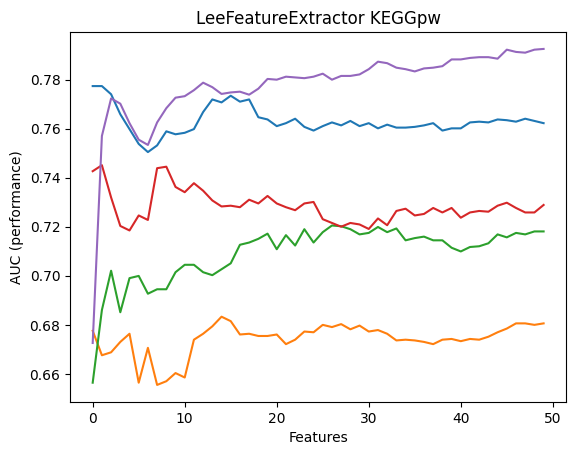

<Figure size 640x480 with 0 Axes>

In [47]:
performance = []
for token in tokens:
    performance.append([token['output'][6]['BinaryNearestMeanClassifier_V1'][perf][0]
        for perf in list(token['output'][6]['BinaryNearestMeanClassifier_V1'].keys())[:50]])
%matplotlib inline
plt.plot(numpy.transpose(performance))
plt.xlabel('Features')
plt.ylabel('AUC (performance)')
plt.title(token['output'][1]+' '+str(token['output'][2]))
plt.show()
figName = 'performance_'+filebase+'.png'
plt.savefig(results_dir+'/'+figName)
plt.clf()

In [51]:
print('Write plot to iRODS: '+coll.path+'/'+figName)
session.data_objects.put(results_dir+'/'+figName, coll.path+'/'+figName)
obj = session.data_objects.get(coll.path+'/'+figName)
obj.metadata.add('prov:wasDerivedFrom', 'http://dx.doi.org/10.6084/m9.figshare.3119248.v1')
obj.metadata.add('DATATYPE', 'ACES results')
obj.metadata.add('prov:SoftwareAgent', filebase)

Write plot to iRODS: /nluu12p/home/research-test-christine/aces_results_0/performance_U133A_combat_DMFS_Lee_nwGeneSetsKEGG_raw.json.png


CATALOG_ALREADY_HAS_ITEM_BY_THAT_NAME: None

In [49]:
# Extract 50 most differentially expressed features
bestFeatures = []
for token in tokens:
    _, genes, features = json.loads((token['output'][5]))
    if item[1][1] != None:
        genelist = [genes[feat] for sublist in features[:10] for feat in sublist]
    else:
        genelist = features[:10]
    bestFeatures.append(genelist)
csvName = 'features_'+filebase+'.csv'
with open(results_dir+'/'+csvName, 'w') as csvfile:
    writer = csv.writer(csvfile, delimiter=',')
    writer.writerows(bestFeatures)

In [52]:
# Upload to iRODS
print('Write feature csv to iRODS: '+coll.path+'/'+csvName)
session.data_objects.put(results_dir+'/'+csvName, coll.path+'/'+csvName)
obj = session.data_objects.get(coll.path+'/'+csvName)
obj.metadata.add('prov:wasDerivedFrom', 'http://dx.doi.org/10.6084/m9.figshare.3119248.v1')
obj.metadata.add('DATATYPE', 'ACES results')
obj.metadata.add('prov:SoftwareAgent', filebase)

Write feature csv to iRODS: /nluu12p/home/research-test-christine/aces_results_0/features_U133A_combat_DMFS_Lee_nwGeneSetsKEGG_raw.json.csv


CATALOG_ALREADY_HAS_ITEM_BY_THAT_NAME: None

### 8. Share the data
Let's indicate a person or a group with which we want to share the data and adjust the accession to our iRODS results folder:

In [ ]:
share = "<USER OR GROUP>"
print(coll.path)

In [ ]:
for _, _, objs in coll.walk():
    for obj in objs:
        try:
            acl = iRODSAccess('read', obj.path, share, session.zone)
            session.permissions.set(acl)
        except:
            print("User or group unknown: " + share)


### 9. Last step: Clean up
To free storage for other users let us clean up the scratch file system. All of our result data is in iRODS, so we will not need them any longer.

In [53]:
print("Cleaning up: ", data_dir)
print("Cleaning up: ", results_dir)

Cleaning up:  /Users/staig001/aces_data
Cleaning up:  /Users/staig001/aces_results


In [54]:
from shutil import rmtree
print("Removing local data in", data_dir)
rmtree(data_dir)
print("Removing local data in", results_dir)
rmtree(results_dir)

Removing local data in /Users/staig001/aces_data
Removing local data in /Users/staig001/aces_results


## Remarks
We have seen that parameter sweeps can become quite elaborate. You might want to think beforehand which output do I really need for my analysis and interpretation.
Instead of running everything in many nested for-loops we defined tokens that decode the parameter setting of a run.

We also saw that the calculation of only one combination of data and algorithm can take some time. So we want to setup the whole pipeline and run it remotely (not interactively) on an HPC cluster.
The tokenisation of the single parameter combinations also gives us the chance to start several jobs each considering a different set of tokens. The results however will be gathered in iRODS no matter where the tokens are calculated.

Next step: Run the pipeline on the HPC ... see you there.